# Classifying Tweet Emotions

In [1]:
# Import necessary modules
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pylab as plt
#import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix

#pd.set_option('display.max_colwidth', 160)

In [3]:
# Read data
df = pd.read_pickle('data/emotions_preprocessed.pkl')

In [4]:
df.head()

,sentiment,content,polarity,mention_count,hashtag_count,char_count,has_link
1,sadness,layin n bed with a headache ughhhh...waitin on...,negative,0,0,59,0
2,sadness,funeral ceremony...gloomy friday...,negative,0,0,35,0
3,enthusiasm,wants to hang out with friends soon!,positive,0,0,36,0
4,neutral,@user we want to trade with someone who has ho...,neutral,1,0,77,0
5,worry,re-pinging @user why didn't you go to prom? bc...,negative,1,0,75,0


## Model

### Transforming Data - Create X and y

In [239]:
# Create features and target
X = df.drop(['sentiment', 'polarity'], axis=1)
y = df.sentiment

# Split training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=57)

### Vectorizing Tweets

#### `CountVectorizer`

In [240]:
# Initialize count vectorizer
count_vectorizer = CountVectorizer(stop_words='english', strip_accents='ascii',
                                  min_df=.001)

# Create count train and test variables
X_train_bow = count_vectorizer.fit_transform(X_train.content)
X_test_bow = count_vectorizer.transform(X_test.content)

# Convert matrices into a DataFrame
X_train_bow_df = pd.DataFrame(X_train_bow.toarray())
X_test_bow_df = pd.DataFrame(X_test_bow.toarray())

# Map the column names to vocabulary 
X_train_bow_df.columns = count_vectorizer.get_feature_names()
X_test_bow_df.columns = count_vectorizer.get_feature_names()

In [241]:
X_train_bow_df.shape

(28964, 946)

In [242]:
X_train_bow_df.columns

Index(['10', '100', '11', '12', '14', '15', '1st', '20', '24', '25',
       ...
       'yep', 'yes', 'yesterday', 'yo', 'young', 'youtube', 'yr', 'yum',
       'yummy', 'yup'],
      dtype='object', length=946)

#### Multinomial Naive Bayes Model

In [243]:
# Drop 'content'
X_train.drop('content', axis=1, inplace=True)
X_test.drop('content', axis=1, inplace=True)

# Merge data
X_train = X_train.reset_index(drop=True).join(X_train_bow_df)
X_test = X_test.reset_index(drop=True).join(X_test_bow_df)
X_test.fillna(0, inplace=True)

/Users/stb/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


##### Emotions

In [244]:
# Create a MulitnomialNB model
clf_nb = MultinomialNB()

clf_nb.fit(X_train, y_train)

# Run predict on count test data to get predictions
count_nb_pred = clf_nb.predict(X_test)

# Calculate the accuracy of predictions
count_nb_score = clf_nb.score(X_test, y_test)

print('NaiveBayes Count Score: ', count_nb_score, '\n')
print(confusion_matrix(y_test, count_nb_pred, labels=y.unique()))

NaiveBayes Count Score:  0.3360952874158467 

[[ 307    3  308  495   26   32    9   39   65    0   10    0]
 [  15    0   88   46    2   14    3    2   26    0    1    0]
 [ 119    6 1074  573   31   86   22   16  191    1   15    0]
 [ 241    9  576  955   30   55   20   35  147    2   13    0]
 [  39    1  186  177   33   45    5    5   62    0    6    0]
 [  36    2  185  126   13  359   10    0  174    0   17    0]
 [  16    1  149   96    8   21   23    2  111    0    4    0]
 [  39    0   65  112    3    8    1   61    9    0    2    0]
 [  43    2  390  203   24  165   30    3  406    0   25    0]
 [  10    0   10   21    0    2    0    3    0    1    0    0]
 [  20    0  123  101    6   25    7    6   55    0   26    0]
 [   0    0    7   17    0    2    1    0    0    0    1    0]]


In [245]:
# Print Confusion Matrix
labels = np.unique(y_test)
cm =  confusion_matrix(y_test, count_nb_pred, labels=labels)
pd.DataFrame(cm, index=labels, columns=labels)

,anger,boredom,enthusiasm,fun,happiness,hate,love,neutral,relief,sadness,surprise,worry
anger,0,0,0,1,0,0,2,7,1,0,0,17
boredom,0,1,0,0,0,3,2,10,0,10,0,21
enthusiasm,0,0,0,3,26,2,14,88,1,15,2,46
fun,0,0,1,23,111,2,21,149,4,16,8,96
happiness,0,0,2,30,406,3,165,390,25,43,24,203
hate,0,0,0,1,9,61,8,65,2,39,3,112
love,0,0,2,10,174,0,359,185,17,36,13,126
neutral,0,1,6,22,191,16,86,1074,15,119,31,573
relief,0,0,0,7,55,6,25,123,26,20,6,101
sadness,0,0,3,9,65,39,32,308,10,307,26,495


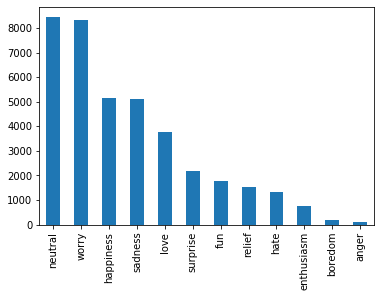

In [246]:
df.sentiment.value_counts().plot.bar()

##### Polarity

In [247]:
# Create features and target
X = df.drop(['sentiment', 'polarity'], axis=1)
y = df.polarity

# Split training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=57)

# Initialize count vectorizer
count_vectorizer = CountVectorizer(stop_words='english', strip_accents='ascii',
                                  min_df=.001)

# Create count train and test variables
X_train_bow = count_vectorizer.fit_transform(X_train.content)
X_test_bow = count_vectorizer.transform(X_test.content)

# Convert matrices into a DataFrame
X_train_bow_df = pd.DataFrame(X_train_bow.toarray())
X_test_bow_df = pd.DataFrame(X_test_bow.toarray())

# Map the column names to vocabulary 
X_train_bow_df.columns = count_vectorizer.get_feature_names()
X_test_bow_df.columns = count_vectorizer.get_feature_names()

# Drop 'content'
X_train.drop('content', axis=1, inplace=True)
X_test.drop('content', axis=1, inplace=True)

# Merge data
X_train = X_train.reset_index(drop=True).join(X_train_bow_df)
X_test = X_test.reset_index(drop=True).join(X_test_bow_df)
X_test.fillna(0, inplace=True)

# Create a MulitnomialNB model
clf_nb = MultinomialNB()

clf_nb.fit(X_train, y_train)

# Run predict on count test data to get predictions
count_nb_pred = clf_nb.predict(X_test)

# Calculate the accuracy of predictions
count_nb_score = clf_nb.score(X_test, y_test)

print('NaiveBayes Count Score: ', count_nb_score, '\n')
print(confusion_matrix(y_test, count_nb_pred, labels=y.unique()))

/Users/stb/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


NaiveBayes Count Score:  0.5575349559813568 

[[2546  778  428]
 [ 998 2354  417]
 [ 854  797  483]]


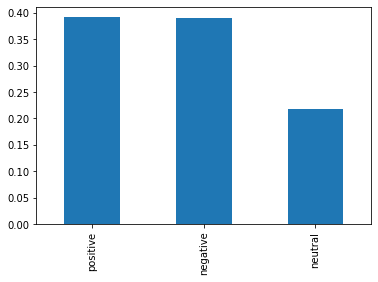

In [248]:
df.polarity.value_counts(normalize=True).plot.bar()

In [249]:
# #from data.helper_functions import plot_confusion_matrix

# # Plot the confusion matrix
# plot_confusion_matrix(confusion_matrix(y_test, count_nb_pred).round(), classes=y.unique(), title="Count NB Confusion Matrix", normalize=False)

#### `TfidfVectorizer`

In [250]:
# Create features and target
X = df.drop(['sentiment', 'polarity'], axis=1)
y = df.sentiment

# Split training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=57)

In [251]:
# Initialize tfidf vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english', min_df=100)

# Create tfidf train and test variables
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train.content) 
X_test_tfidf = tfidf_vectorizer.transform(X_test.content)

#### Multinomial Naive Bayes Model

In [190]:
# X_test_tfidf.toarray()[np.isnan(X_test_tfidf.toarray())] = 0

In [254]:
# Create a MulitnomialNB model
tfidf_nb = MultinomialNB()

tfidf_nb.fit(X_train_tfidf, y_train)

# Run predict on TF-IDF test data to get predictions
tfidf_nb_pred = tfidf_nb.predict(X_test_tfidf)

# Calculate the accuracy of predictions
tfidf_nb_score = tfidf_nb.score(X_test_tfidf, y_test)

print('NaiveBayes Tfidf Score: ', tfidf_nb_score)

NaiveBayes Tfidf Score:  0.3232522009321595


In [255]:
# Print Confusion Matrix
labels = np.unique(y_test)
cm =  confusion_matrix(y_test, tfidf_nb_pred, labels=labels)
pd.DataFrame(cm, index=labels, columns=labels)

,anger,boredom,enthusiasm,fun,happiness,hate,love,neutral,relief,sadness,surprise,worry
anger,0,0,0,0,1,0,3,10,0,1,0,13
boredom,0,0,0,0,1,0,2,21,0,4,0,19
enthusiasm,0,0,0,0,25,0,11,98,0,5,0,58
fun,0,0,0,0,94,0,10,196,0,6,0,125
happiness,0,0,0,0,350,0,129,491,3,13,4,301
hate,0,0,0,0,9,18,6,111,0,18,0,138
love,0,0,0,0,170,0,277,281,1,16,2,175
neutral,0,0,0,0,140,4,51,1282,3,50,2,602
relief,0,0,0,0,51,1,13,177,8,13,0,106
sadness,0,0,0,0,42,9,24,409,0,158,1,651


### Linear SVC Model (Emotions)

In [256]:
# Create a LinearSVC model
tfidf_svc = LinearSVC()

# Train model
tfidf_svc.fit(X_train_tfidf, y_train)

# Run predict on tfidf test data to get predictions
tfidf_svc_pred = tfidf_svc.predict(X_test_tfidf)

# Calculate accuracy using the metrics module
tfidf_svc_score = tfidf_svc.score(X_test_tfidf, y_test)

print("LinearSVC Score:   %0.3f" % tfidf_svc_score)

# Print Confusion Matrix
labels = np.unique(y_test)
cm =  confusion_matrix(y_test, tfidf_svc_pred, labels=labels)
pd.DataFrame(cm, index=labels, columns=labels)

LinearSVC Score:   0.343


,anger,boredom,enthusiasm,fun,happiness,hate,love,neutral,relief,sadness,surprise,worry
anger,0,0,0,0,1,0,3,11,1,1,0,11
boredom,0,0,0,0,2,0,2,22,0,5,0,16
enthusiasm,0,0,0,0,36,0,13,87,0,8,1,52
fun,0,0,0,2,139,1,18,150,0,11,3,107
happiness,0,0,0,4,481,0,146,383,8,30,9,230
hate,0,0,0,1,17,48,8,98,0,23,0,105
love,0,0,0,4,198,1,360,218,2,28,5,106
neutral,0,0,0,4,216,5,64,1241,4,86,4,510
relief,0,0,0,0,91,5,17,132,17,11,0,96
sadness,0,0,0,2,67,26,41,373,0,259,5,521


### Linear SVC Model (Polarity)

In [261]:
# Create features and target
X = df.drop(['sentiment', 'polarity'], axis=1)
y = df.polarity

# Split training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=57)

# Initialize tfidf vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english', min_df=100)

# Create tfidf train and test variables
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train.content) 
X_test_tfidf = tfidf_vectorizer.transform(X_test.content)

# Create a LinearSVC model
tfidf_svc = LinearSVC()

# Train model
tfidf_svc.fit(X_train_tfidf, y_train)

# Run predict on tfidf test data to get predictions
tfidf_svc_pred = tfidf_svc.predict(X_test_tfidf)

# Calculate accuracy using the metrics module
tfidf_svc_score = tfidf_svc.score(X_test_tfidf, y_test)

print("LinearSVC Score:   %0.3f" % tfidf_svc_score)

# Print Confusion Matrix
labels = np.unique(y_test)
cm =  confusion_matrix(y_test, tfidf_svc_pred, labels=labels)
pd.DataFrame(cm, index=labels, columns=labels)

LinearSVC Score:   0.561


,negative,neutral,positive
negative,2572,298,882
neutral,999,423,712
positive,1099,253,2417


### Pipeline

#### MultinomialNB with Pipeline

In [257]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])

text_clf.fit(X_train.content, y_train)

print(text_clf.score(X_test.content, y_test))

y_pred = text_clf.predict(X_test.content)

# Print Confusion Matrix
labels = np.unique(y_test)
cm =  confusion_matrix(y_test, y_pred, labels=labels)
pd.DataFrame(cm, index=labels, columns=labels)

0.2995339202485759


,anger,boredom,enthusiasm,fun,happiness,hate,love,neutral,relief,sadness,surprise,worry
anger,0,0,0,0,0,0,0,8,0,0,0,20
boredom,0,0,0,0,0,0,0,13,0,0,0,34
enthusiasm,0,0,0,0,2,0,2,94,0,1,0,98
fun,0,0,0,0,29,0,2,195,0,1,0,204
happiness,0,0,0,0,157,0,36,549,0,0,0,549
hate,0,0,0,0,1,0,0,56,0,4,0,239
love,0,0,0,0,74,0,130,328,0,0,0,390
neutral,0,0,0,0,39,0,20,1034,0,10,0,1031
relief,0,0,0,0,7,0,5,157,0,0,0,200
sadness,0,0,0,0,4,0,0,254,0,15,0,1021


In [258]:
from sklearn.model_selection import GridSearchCV

parameters = {
    'vect__stop_words': ['english', None],
    'vect__max_df': [0.7, 0.8, 0.9, 1.0],
    'vect__min_df': [10, .001, .01, 0.1],    
    'clf__alpha': (0.1, 1.0)
}

grid_search = GridSearchCV(text_clf, parameters, cv=3,
                           n_jobs=-1, verbose=1)

In [259]:
grid_search.fit(X_train.content, y_train)

print('score', grid_search.score(X_test.content, y_test))
print('-----')

print('GridSearchCV:')
y_pred = grid_search.predict(X_test.content)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

# Print Confusion Matrix
labels = np.unique(y_test)
cm =  confusion_matrix(y_test, y_pred, labels=labels)
pd.DataFrame(cm, index=labels, columns=labels)

Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:   56.8s finished


score 0.3328845157949249
-----
GridSearchCV:
Best score: 0.331
Best parameters set:
	clf__alpha: 0.1
	vect__max_df: 0.7
	vect__min_df: 0.001
	vect__stop_words: None


,anger,boredom,enthusiasm,fun,happiness,hate,love,neutral,relief,sadness,surprise,worry
anger,0,0,0,0,1,0,2,8,0,0,0,17
boredom,0,0,0,0,0,1,1,15,0,4,0,26
enthusiasm,0,0,0,0,25,0,6,103,0,4,0,59
fun,0,0,0,1,91,0,8,203,0,5,0,123
happiness,0,0,0,0,385,0,118,488,0,15,1,284
hate,0,0,0,0,5,14,4,86,0,28,0,163
love,0,0,0,0,162,0,275,277,0,16,1,191
neutral,0,0,0,0,163,0,54,1217,1,55,2,642
relief,0,0,0,0,51,0,14,166,3,12,0,123
sadness,0,0,0,0,34,7,16,366,0,155,0,716


#### LinearSVC Classifier with Pipeline

In [260]:
svc_pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LinearSVC()),
])

parameters = {
    'vect__stop_words': ['english', None],
    'vect__max_df': [0.6, 0.75, 1.0],
    'vect__min_df': [0.001, 0.1, 0.01],
    'clf__class_weight': ['balanced', None]
}

grid_search = GridSearchCV(svc_pipeline, parameters, cv=3,
                           n_jobs=-1, verbose=1)

grid_search.fit(X_train.content, y_train)

print('score', grid_search.score(X_test.content, y_test))
print('-----')

print('GridSearchCV:')
y_pred = grid_search.predict(X_test.content)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

# Print Confusion Matrix
labels = np.unique(y_test)
cm =  confusion_matrix(y_test, y_pred, labels=labels)
pd.DataFrame(cm, index=labels, columns=labels)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:  2.8min finished


score 0.3554634904194718
-----
GridSearchCV:
Best score: 0.347
Best parameters set:
	clf__class_weight: None
	vect__max_df: 0.6
	vect__min_df: 0.001
	vect__stop_words: None


,anger,boredom,enthusiasm,fun,happiness,hate,love,neutral,relief,sadness,surprise,worry
anger,0,0,0,0,2,0,2,5,1,1,0,17
boredom,0,0,0,0,3,3,3,14,0,7,0,17
enthusiasm,0,0,0,1,34,0,12,91,1,9,1,48
fun,0,0,0,6,143,2,17,136,1,19,3,104
happiness,0,0,0,10,493,1,148,354,14,53,14,204
hate,0,0,0,0,13,61,6,66,0,34,1,119
love,0,0,0,8,195,1,373,192,4,32,6,111
neutral,0,1,1,12,230,9,77,1184,8,125,16,471
relief,0,0,0,1,86,4,24,120,17,23,2,92
sadness,0,0,0,3,68,30,39,305,1,320,9,519
